In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bases import linear, polynomial_1d, polynomial, sinusoidal_1d, sinusoidal, radial
from metrics import MSE
from surrogate_model import SurrogateModel
from error_estimate import holdout_sets, holdout_estimate
from error_estimate import k_fold_cross_validation_sets, k_fold_cross_validation_estimate
from error_estimate import bootstrap_sets, bootstrap_estimate, leave_one_out_bootstrap_estimate, bootstrap_632_estimate

In [2]:
plots_per_row = 4

def plot_and_estimate(bases_sets, df, smoothing):
    X = df[df.columns.drop(['y'])].to_numpy()
    y = df['y'].to_numpy()
    (m, d) = X.shape

    X_M = np.amax(X, axis=0)
    X_m = np.amin(X, axis=0)

    y_M = np.amax(y)
    y_m = np.amin(y)

    plot_rows = max(2, len(bases_sets) // plots_per_row + bool(len(bases_sets) % plots_per_row))
    figure, axis = plt.subplots(plot_rows, plots_per_row, figsize=(6 * plots_per_row, 6 * plot_rows))

    id = []
    r1 = []
    r2 = []
    r3 = []

    idx = 0
    for name, bases_set in bases_sets.items():
        axis[idx // plots_per_row, idx % plots_per_row].set_ylim([y_m - 50.0, y_M + 50.0])
        axis[idx // plots_per_row, idx % plots_per_row].scatter(X, y)
        axis[idx // plots_per_row, idx % plots_per_row].set_title(name)

        model = SurrogateModel(bases_set, smoothing)
        model.fit(X, y)
        
        id.append(name)
        r1.append(holdout_estimate(X, y, bases_set, smoothing, MSE))
        r2.append(k_fold_cross_validation_estimate(X, y, bases_set, smoothing, MSE))
        r3.append(bootstrap_632_estimate(X, y, bases_set, smoothing, MSE))

        if d == 1:
            Xp = np.arange(X_m - 5.0, X_M + 5.0, 0.1)
            yp = model.predict(Xp.reshape(-1, 1))
            axis[idx // plots_per_row, idx % plots_per_row].plot(Xp, yp, c='red')

        idx += 1

    estimate_results = pd.DataFrame()

    estimate_results['Bases set']               = id
    estimate_results['Holdout']                 = r1
    estimate_results['K-fold cross validation'] = r2
    estimate_results['Bootstrap']               = r3

    return estimate_results

,Bases set,Holdout,K-fold cross validation,Bootstrap
0,linear,1.179106e+03,718.312548,4.940288e+02
1,polynomial (k = 3),1.197237e+03,1469.022031,1.528327e+03
2,polynomial (k = 5),8.026691e+04,1295.093153,2.583499e+03
3,polynomial (k = 9),8.504832e+09,18234.739885,2.323081e+09
4,sinusoidal (k = 2),3.868560e+04,38184.703376,4.851188e+04
5,sinusoidal (k = 8),9.414185e+04,93875.556759,7.261477e+04
6,"radial (f(r) = r, p = 2)",3.194491e+03,798.125424,5.360786e+02
7,"radial (f(r) = r^2log(r), p = 2)",2.319203e+03,800.409192,1.492677e+03


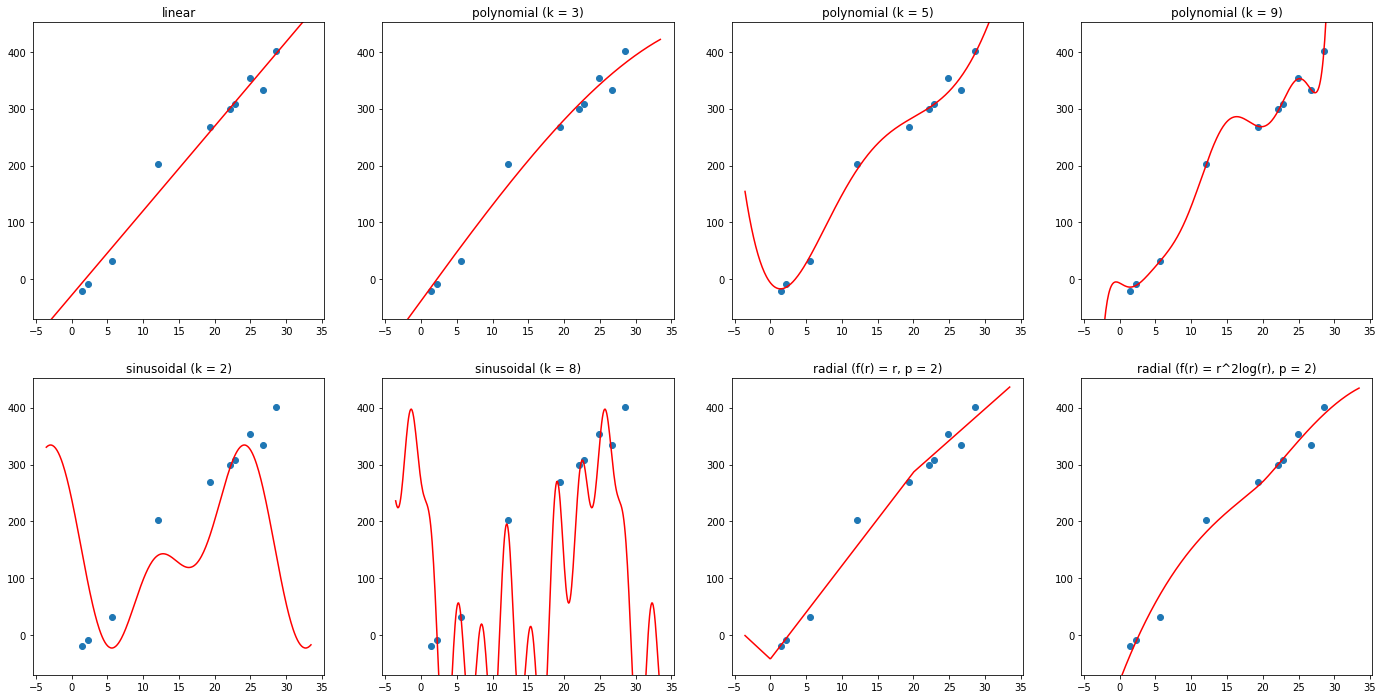

In [3]:
m_0 = 10
d_0 = 1
v_0 = 2.5

w_0 = (np.random.random(d_0 + 1) - 0.5) *np.array([10.0, 50.0])

X_0 = np.array([np.random.random(d_0) * 40.0 for _ in range(m_0)])
y_0 = np.array([w_0[0] + sum([w_0[i + 1] * x[i] for i in range(d_0)]) for x in X_0]) + (np.random.random(m_0) - 0.5) * v_0 * sum(w_0[1:]) * math.sqrt(m_0)

a = np.amin(X_0, axis=0)
b = np.amax(X_0, axis=0)

df_0 = pd.DataFrame()
df_0[['x' + str(i) for i in range(d_0)]] = X_0
df_0['y'] = y_0
df_0.to_csv('./example_data/example_0.csv', index=False)

bss = {
    'linear': linear(1), 
    'polynomial (k = 3)': polynomial(1, 3), 
    'polynomial (k = 5)': polynomial(1, 5),
    'polynomial (k = 9)': polynomial(1, 9),
    'sinusoidal (k = 2)': sinusoidal(1, 2, a, b),
    'sinusoidal (k = 8)': sinusoidal(1, 8, a, b),
    'radial (f(r) = r, p = 2)': radial(lambda r: r, [(0), (20), (40)]),
    'radial (f(r) = r^2log(r), p = 2)': radial(lambda r: r * r * math.log(r), [(0), (20), (40)])
}

plot_and_estimate(bss, df_0, 0.5)

,Bases set,Holdout,K-fold cross validation,Bootstrap
0,linear,267532.867651,258527.371614,259836.401455
1,polynomial (k = 3),251208.059623,246665.236342,241809.815403
2,polynomial (k = 5),299458.847325,258858.084430,256458.605187
3,polynomial (k = 9),476967.652502,145054.735855,146504.199518
4,sinusoidal (k = 2),272681.393939,271957.529800,267453.639785
5,sinusoidal (k = 16),354155.753025,61255.147991,106489.812583
6,"radial (f(r) = r, p = 2)",274671.634373,266566.340699,269760.780561
7,"radial (f(r) = r^2log(r), p = 2)",272811.361963,267211.185840,266232.010640


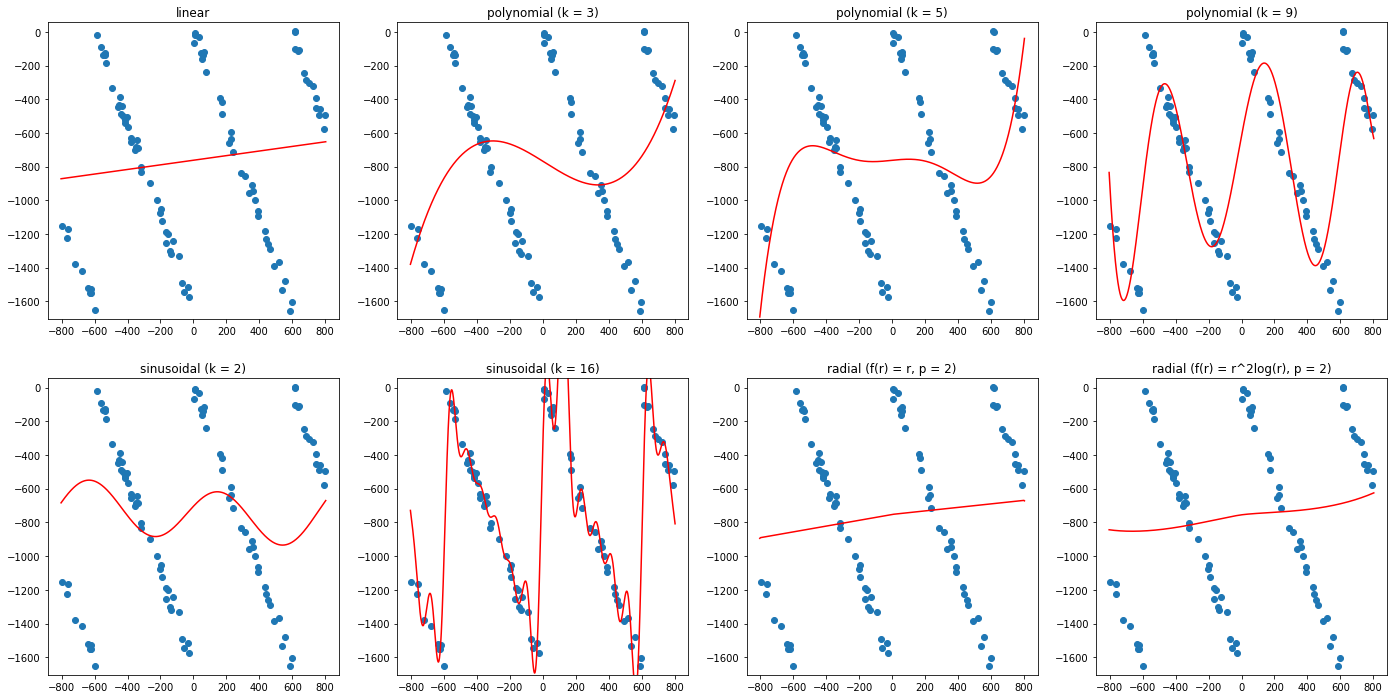

In [12]:
m_1 = 100
d_1 = 1
v_1 = 15.0

w_1 = (np.random.random(d_1 + 1) - 0.5) * np.array([10.0, 10.0])
T = 60.0 * sum(w_1[1:]) * math.sqrt(m_1)
b = -25.0

X_1 = np.array([np.random.random(d_1) * 1600.0 - 800.0 for _ in range(m_1)])
y_1 = np.array([w_1[0] + sum([w_1[i + 1] * x[i] for i in range(d_1)]) - T * np.floor(sum([w_1[i + 1] * x[i] for i in range(d_1)]) / T) for x in X_1]) + (np.random.random(m_1) - 0.5) * v_1 * sum(w_1[1:]) * math.sqrt(m_1)

a = np.amin(X_1, axis=0)
b = np.amax(X_1, axis=0)

df_1 = pd.DataFrame()
df_1[['x' + str(i) for i in range(d_1)]] = X_1
df_1['y'] = y_1
df_1.to_csv('./example_data/example_1.csv', index=False)

bss = {
    'linear': linear(1), 
    'polynomial (k = 3)': polynomial(1, 3), 
    'polynomial (k = 5)': polynomial(1, 5),
    'polynomial (k = 9)': polynomial(1, 9),
    'sinusoidal (k = 2)': sinusoidal(1, 2, a, b),
    'sinusoidal (k = 8)': sinusoidal(1, 8, a, b),
    'radial (f(r) = r, p = 2)': radial(lambda r: r, [(-800), (0), (800)]),
    'radial (f(r) = r^2log(r), p = 2)': radial(lambda r: r * r * math.log(r), [(-800), (0), (800)])
}

plot_and_estimate(bss, df_1, 0.5)